# Linear Regression

Welcome to your second assignment. This exercise gives you a brief introduction to linear regression. The exercise is to be implemented in Python. Even if you've used Python before, this will help familiarize you with functions we'll need.  

**Instructions:**
- You will be using Python 3.
- Avoid using for-loops and while-loops, unless you are explicitly told to do so.
- Do not modify the (# GRADED FUNCTION [function name]) comment in some cells. Your work would not be graded if you change this. Each cell containing that comment should only contain one function.
- After coding your function, run the cell right below it to check if your result is correct.
- The token generated by Coursera (COURSERA_TOKEN) expires every <b>30 minutes</b>. It is advisable to always work with the most recent generated token so as to avoid any submission related errors. If you receive such error messages, rerun the cells containing your code and the GRADED FUNCTION in the same order. 


**After this assignment you will:**
- Be able to implement linear regression model using statsmodels, scikit-learn, and tensorflow
- Work with simulated non-linear dataset
- Compare model performance (quality of fit) of both models

- - The blue button "Submit Assignment" does not work. After running all the cells, please go directly to Assignment-> My submission to see your results.

Let's get started!

## About iPython Notebooks ##

iPython Notebooks are interactive coding environments embedded in a webpage. You will be using iPython notebooks in this class. You only need to write code between the ### START CODE HERE ### and ### END CODE HERE ### comments. After writing your code, you can run the cell by either pressing "SHIFT"+"ENTER" or by clicking on "Run Cell" (denoted by a play symbol) in the upper bar of the notebook. 

We will often specify "(≈ X lines of code)" in the comments to tell you about how much code you need to write. It is just a rough estimate, so don't feel bad if your code is longer or shorter.

In [69]:
import os
import numpy as np

import sys
sys.path.append("..")
import grading

try:
    import matplotlib.pyplot as plt
    %matplotlib inline
except: pass

import pandas as pd

import tensorflow as tf
from tensorflow.python.layers import core as core_layers
try:
    from mpl_toolkits.mplot3d import Axes3D
except: pass

In [70]:
### ONLY FOR GRADING. DO NOT EDIT ###
submissions=dict()
assignment_key="QNZTAPW2Eeeg_w5MCivhhg" 
all_parts=["dtA5d", "2inmf", "FCpek","78aDd","qlQVj"]
### ONLY FOR GRADING. DO NOT EDIT ###

In [71]:
COURSERA_TOKEN ="KNdtBReOFLfmNOY2" # the key provided to the Student under his/her email on submission page
COURSERA_EMAIL ="javier_a_jaime@yahoo.com.mx" # the email

In [72]:
def reset_graph(seed=42):
    """
    Utility function to reset current tensorflow computation graph
    and set the random seed 
    """
    # to make results reproducible across runs
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

## We use artificial data for the following two specifications of regression:

### Linear Regression

$ y(x) = a + b_1 \cdot X_1 + b_2 \cdot X_2 + b_3 \cdot X_3 + \sigma \cdot \varepsilon $ 

where $ \varepsilon \sim N(0, 1) $ is a Gaussian noise, and $ \sigma $ is its volatility, 
with the following choice of parameters:

$ a = 1.0 $

$ b_1, b_2, b_3 = (0.5, 0.2, 0.1) $

$ \sigma = 0.1 $

$ X_1, X_2, X_3 $ will be uniformally distributed in $ [-1,1] $

### Non-Linear Regression

$ y(x) = a + w_{00} \cdot X_1 + w_{01} \cdot X_2 + w_{02} \cdot X_3 + + w_{10} \cdot X_1^2 
+ w_{11} \cdot X_2^2 + w_{12} \cdot X_3^2 +  \sigma \cdot \varepsilon $ 

where

$ w = [[1.0, 0.5, 0.2],[0.5, 0.3, 0.15]]  $

and the rest of parameters is as above, with the same values of $ X_i $

### Generate Data

In [73]:
def generate_data(n_points=10000, n_features=3, use_nonlinear=True, 
                    noise_std=0.1, train_test_split = 4):
    """
    Arguments:
    n_points - number of data points to generate
    n_features - a positive integer - number of features
    use_nonlinear - if True, generate non-linear data
    train_test_split - an integer - what portion of data to use for testing
    
    Return:
    X_train, Y_train, X_test, Y_test, n_train, n_features
    """
    
    # Linear data or non-linear data?
    if use_nonlinear:
        weights = np.array([[1.0, 0.5, 0.2],[0.5, 0.3, 0.15]])
    else:
        weights = np.array([1.0, 0.5, 0.2])
        

    
    bias = np.ones(n_points).reshape((-1,1))
    low = - np.ones((n_points,n_features),'float')
    high = np.ones((n_points,n_features),'float')
        
    np.random.seed(42)
    X = np.random.uniform(low=low, high=high)
    
    np.random.seed(42)
    noise = np.random.normal(size=(n_points, 1))
    noise_std = 0.1
    
    if use_nonlinear:
        Y = (weights[0,0] * bias + np.dot(X, weights[0, :]).reshape((-1,1)) + 
             np.dot(X*X, weights[1, :]).reshape([-1,1]) +
             noise_std * noise)
    else:
        Y = (weights[0] * bias + np.dot(X, weights[:]).reshape((-1,1)) + 
             noise_std * noise)
    
    n_test = int(n_points/train_test_split)
    n_train = n_points - n_test
    
    X_train = X[:n_train,:]
    Y_train = Y[:n_train].reshape((-1,1))

    X_test = X[n_train:,:]
    Y_test = Y[n_train:].reshape((-1,1))
    
    return X_train, Y_train, X_test, Y_test, n_train, n_features

X_train, Y_train, X_test, Y_test, n_train, n_features = generate_data(use_nonlinear=False)
X_train.shape, Y_train.shape

((7500, 3), (7500, 1))

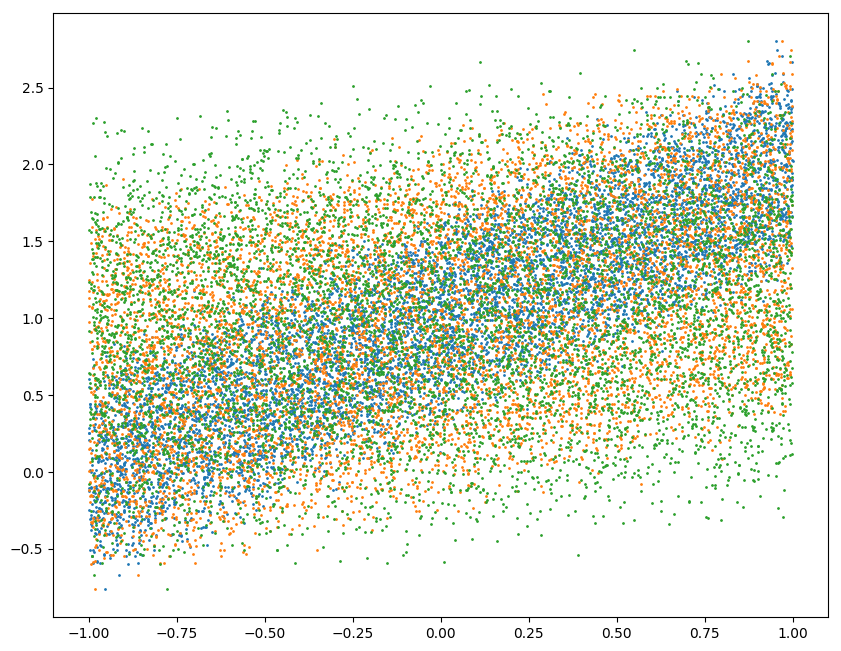

In [115]:
plt.scatter(X_train[:,0],Y_train, s=1)
plt.scatter(X_train[:,1],Y_train, s=1)
plt.scatter(X_train[:,2],Y_train, s=1)
plt.rcParams.update({'figure.figsize':(100,80), 'figure.dpi':100})
plt.show()

### Linear Regression with Numpy

In [74]:
# GRADED FUNCTION: numpy_lin_regress
def numpy_lin_regress(X_train, Y_train):
    """
    numpy_lin_regress - Implements linear regression model using numpy module
    Arguments:
    X_train  - np.array of size (n by k) where n is number of observations 
                of independent variables and k is number of variables
    Y_train - np.array of size (n by 1) where n is the number of observations of dependend variable
    
    Return:
    np.array of size (k+1 by 1) of regression coefficients
    """
    ### START CODE HERE ### (≈ 3 lines of code)
    
    # number of features
    n_features = X_train.shape[0]
    # add the column of ones
    X = np.concatenate((np.ones((n_features,1)),X_train),axis = 1)
    # default answer, replace this
    theta_numpy = np.linalg.inv(np.dot(X.T,X)).dot(X.T).dot(Y_train).reshape(-1,1)
    # theta_numpy = np.array([0.] * (ndim + 1)) 
    ### END CODE HERE ###
    return theta_numpy

In [75]:
### GRADED PART (DO NOT EDIT) ###
theta_numpy = numpy_lin_regress(X_train, Y_train)
part_1 = list(theta_numpy.squeeze())
try:
    part1 = " ".join(map(repr, part_1))
except TypeError:
    part1 = repr(part_1)
submissions[all_parts[0]]=part1
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key,all_parts[:1],all_parts,submissions)
theta_numpy.squeeze()
### GRADED PART (DO NOT EDIT) ###

Submission successful, please check on the coursera grader page for the status


array([ 0.99946227,  0.99579039,  0.499198  ,  0.20019798])

### Linear Regression with Sklearn

In [76]:
# GRADED FUNCTION: sklearn_lin_regress
def sklearn_lin_regress(X_train, Y_train):
    """
    Arguments:
    X_train  - np.array of size (n by k) where n is number of observations 
                of independent variables and k is number of variables
    Y_train - np.array of size (n by 1) where n is the number of observations of dependend variable
    
    Return:
    np.array of size (k+1 by 1) of regression coefficients
    """ 
    from sklearn.linear_model import LinearRegression
    ### START CODE HERE ### (≈ 3 lines of code)
    # use lin_reg to fit training data
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, Y_train)
    theta_sklearn = np.append(lin_reg.intercept_,lin_reg.coef_).reshape(-1,1)
    ### END CODE HERE ###
    return theta_sklearn

In [77]:
### GRADED PART (DO NOT EDIT) ###
theta_sklearn = sklearn_lin_regress(X_train, Y_train)
part_2 = list(theta_sklearn.squeeze())
try:
    part2 = " ".join(map(repr, part_2))
except TypeError:
    part2 = repr(part_2)
submissions[all_parts[1]]=part2
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key,all_parts[:2],all_parts,submissions)
theta_sklearn.squeeze()
### GRADED PART (DO NOT EDIT) ###

Submission successful, please check on the coursera grader page for the status


array([ 0.99946227,  0.99579039,  0.499198  ,  0.20019798])

### Linear Regression with Tensorflow

In [78]:
# GRADED FUNCTION: tf_lin_regress
def tf_lin_regress(X_train, Y_train):
    """
    Arguments:
    X_train  - np.array of size (n by k) where n is number of observations 
                of independent variables and k is number of variables
    Y_train - np.array of size (n by 1) where n is the number of observations of dependend variable
    
    Return:
    np.array of size (k+1 by 1) of regression coefficients
    """
    ### START CODE HERE ### (≈ 7-8 lines of code)
    # add the column of ones
    Xn = np.hstack((np.ones((X_train.shape[0],1)),X_train))
    # define theta for later evaluation
    X = tf.constant(Xn, dtype = tf.float32, name ='X')
    y = tf.constant(Y_train, dtype = tf.float32, name ='y')
    theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(tf.transpose(X),X)),tf.transpose(X)),y)
    ### END CODE HERE ###
    with tf.Session() as sess:
        theta_value = theta.eval()
    return theta_value

In [79]:
### GRADED PART (DO NOT EDIT) ###
theta_tf = tf_lin_regress(X_train, Y_train)
part_3 = list(theta_tf.squeeze())
try:
    part3 = " ".join(map(repr, part_3))
except TypeError:
    part3 = repr(part_3)
submissions[all_parts[2]]=part3
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key,all_parts[:3],all_parts,submissions)
theta_tf.squeeze()
### GRADED PART (DO NOT EDIT) ###

Submission successful, please check on the coursera grader page for the status


array([ 0.99946201,  0.99579054,  0.49919799,  0.20019798], dtype=float32)

In [80]:
class LinRegressNormalEq:
    """
    class LinRegressNormalEq - implements normal equation, maximum likelihood estimator (MLE) solution
    """
    def __init__(self, n_features, learning_rate=0.05, L=0):
        import math as m
        # input placeholders
        self.X = tf.placeholder(tf.float32, [None, n_features], name="X") 
        self.Y = tf.placeholder(tf.float32, [None, 1], name="Y")
    
        # regression parameters for the analytical solution using the Normal equation
        self.theta_in = tf.placeholder(tf.float32, [n_features+1,None])

        # Augmented data matrix is obtained by adding a column of ones to the data matrix
        data_plus_bias = tf.concat([tf.ones([tf.shape(self.X)[0], 1]), self.X], axis=1)
        
        XT = tf.transpose(data_plus_bias)
        
        #############################################
        # The normal equation for Linear Regression
        
        self.theta = tf.matmul(tf.matmul(
            tf.matrix_inverse(tf.matmul(XT, data_plus_bias)), XT), self.Y)
        
        # mean square error in terms of theta = theta_in
        self.lr_mse = tf.reduce_mean(tf.square(
            tf.matmul(data_plus_bias, self.theta_in) - self.Y))
                       
        #############################################
        # Estimate the model using the Maximum Likelihood Estimation (MLE)
        
        # regression parameters for the Maximum Likelihood method
        # Note that there are n_features+2 parameters, as one is added for the intercept, 
        # and another one for the std of noise  
        self.weights = tf.Variable(tf.random_normal([n_features+2, 1]))
        
        # prediction from the model
        self.output = tf.matmul(data_plus_bias, self.weights[:-1, :])

        gauss = tf.distributions.Normal(loc=0.0, scale=1.0)

        # Standard deviation of the Gaussian noise is modelled as a square of the 
        # last model weight
        sigma = 0.0001 + tf.square(self.weights[-1]) 
        
        # though a constant sqrt(2*pi) is not needed to find the best parameters, here we keep it
        # to get the value of the log-LL right 
        pi = tf.constant(m.pi)
    
        log_LL = tf.log(0.00001 + (1/( tf.sqrt(2*pi)*sigma)) * gauss.prob((self.Y - self.output) / sigma ))  
        self.loss = - tf.reduce_mean(log_LL)
        
        self.train_step = (tf.train.AdamOptimizer(learning_rate).minimize(self.loss), -self.loss)

In [81]:
# GRADED FUNCTION: run_normal_eq
def run_normal_eq(X_train, Y_train, X_test, Y_test, learning_rate=0.05):
    """
    Implements normal equation using tensorflow, trains the model using training data set
    Tests the model quality by computing mean square error (MSE) of the test data set
    
    Arguments:
    X_train  - np.array of size (n by k) where n is number of observations 
                of independent variables and k is number of variables
    Y_train - np.array of size (n by 1) where n is the number of observations of dependend variable
    
    X_test  - np.array of size (n by k) where n is number of observations 
                of independent variables and k is number of variables
    Y_test - np.array of size (n by 1) where n is the number of observations of dependend variable
    
    
    Return a tuple of:
        - np.array of size (k+1 by 1) of regression coefficients
        - mean square error (MSE) of the test data set
        - mean square error (MSE) of the training data set
    """
    # create an instance of the Linear Regression model class  
    n_features = X_train.shape[1]
    model = LinRegressNormalEq(n_features=n_features, learning_rate=learning_rate)

    ### START CODE HERE ### (≈ 10-15 lines of code)
    # train the model
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        # Normal equation for Linear Regression
        theta_value = sess.run(model.theta, feed_dict ={model.X: X_train, model.Y: Y_train})
        lr_mse_train = sess.run(model.lr_mse, feed_dict ={model.X: X_train, model.Y: Y_train, model.theta_in: theta_value})
        lr_mse_test = sess.run(model.lr_mse, feed_dict ={model.X: X_test, model.Y: Y_test, model.theta_in: theta_value})        
             
    ### END CODE HERE ###
    return theta_value, lr_mse_train, lr_mse_test

### (DO NOT EDIT) ###
theta_value, lr_mse_train, lr_mse_test = run_normal_eq(X_train, Y_train, X_test, Y_test)
### (DO NOT EDIT) ###

In [82]:
### GRADED PART (DO NOT EDIT) ###
part_4 = list(theta_value.squeeze())
try:
    part4 = " ".join(map(repr, part_4))
except TypeError:
    part4 = repr(part_4)
submissions[all_parts[3]]=part4
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key,all_parts[:4],all_parts,submissions)
theta_value.squeeze()
### GRADED PART (DO NOT EDIT) ###

Submission successful, please check on the coursera grader page for the status


array([ 0.99946201,  0.99579054,  0.49919799,  0.20019798], dtype=float32)

In [83]:
# GRADED FUNCTION: run_mle# GRADED 
def run_mle(X_train, Y_train, X_test, Y_test, learning_rate=0.05, num_iter=5000):
    """
    Maximum likelihood Estimate (MLE)
    Tests the model quality by computing mean square error (MSE) of the test data set
    
    Arguments:
    X_train  - np.array of size (n by k) where n is number of observations 
                of independent variables and k is number of variables
    Y_train - np.array of size (n by 1) where n is the number of observations of dependend variable
    
    X_test  - np.array of size (n by k) where n is number of observations 
                of independent variables and k is number of variables
    Y_test - np.array of size (n by 1) where n is the number of observations of dependend variable
    
    
    Return a tuple of:
        - np.array of size (k+1 by 1) of regression coefficients
        - mean square error (MSE) of the test data set
        - mean square error (MSE) of the training data set
    """
    # create an instance of the Linear Regression model class  
    n_features = X_train.shape[1]
    model = LinRegressNormalEq(n_features=n_features, learning_rate=learning_rate)
    
    # train the model
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        # Now train the MLE parameters 
        for _ in range(num_iter):
            (_ , loss), weights = sess.run((model.train_step, model.weights), feed_dict={model.X: X_train, model.Y: Y_train})

        # make test_prediction
        Y_test_predicted = sess.run(model.output, feed_dict={model.X: X_test})

        # output std sigma is a square of the last weight
        std_model = weights[-1]**2 
        sess.close()
    return weights[0:-1].squeeze(), loss, std_model

weights, loss, std_model = run_mle(X_train, Y_train, X_test, Y_test)

In [84]:
### GRADED PART (DO NOT EDIT) ###
part_5 = list(weights.squeeze())
try:
    part5 = " ".join(map(repr, part_5))
except TypeError:
    part5 = repr(part_5)
submissions[all_parts[4]]=part5
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key,all_parts[:5],all_parts,submissions)
weights.squeeze()
### GRADED PART (DO NOT EDIT) ###

Submission successful, please check on the coursera grader page for the status


array([ 0.9994508 ,  0.99580413,  0.49916834,  0.20023532], dtype=float32)